Тут будем искать кластеры похожих данных, чтобы потом добавить их в rule-based классификацию, так как смотреть по одному примеру за раз и добавлять такие редкие классы не очень удобно.

Так как кластеризация нужна не для автоматической обработки данных, а для ручной классификации после, можно взять либо быстрый метод по типу K-means, либо интересный метод по типу DBSCAN или более удобный HDBSCAN.

In [1]:
import pandas as pd
import os

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

os.chdir('../../')

In [2]:
df = pd.read_csv('data/processed/rule_classified.csv')

In [3]:
df_labeled = df[df['answer'].notna()].copy()
# original_indices_labeled = df_labeled.index.copy() # Для последующего объеденения с предсказаниями
df_labeled = df_labeled.reset_index(drop=True)

df_labeled['answer'].value_counts()

answer
Отказ                                     214
Частично удовлетворено                    138
Обращение рассмотрено                     130
Взыскание обращено                        104
Запрос направлен                           80
Возбуждено исполнительное производство     72
Постановление вынесено                     37
Удовлетворено                              27
Заявления и жалобы рассматриваются         26
Объявлен исполнительный розыск             20
Применены меры для исполнения              19
Запрет действий                            14
Производство окончено                       9
Name: count, dtype: int64

In [4]:
from src.classification_utils import split_data, encode_labels

X_train, X_test, y_train, y_test = split_data(df_labeled)
y_train_enc, y_test_enc, le = encode_labels(y_train, y_test)

print(f"{'='*15}Размеры классов тренировочной выборки:{'='*15}\n{y_train.value_counts()}\n")
print(f"{'='*15}Размеры классов тестовой выборки:{'='*15}\n{y_test.value_counts()}")

===============Размеры классов тренировочной выборки:===============
answer
Отказ                                     150
Частично удовлетворено                     97
Обращение рассмотрено                      91
Взыскание обращено                         73
Запрос направлен                           56
Возбуждено исполнительное производство     50
Постановление вынесено                     26
Удовлетворено                              19
Заявления и жалобы рассматриваются         18
Объявлен исполнительный розыск             14
Применены меры для исполнения              13
Запрет действий                            10
Производство окончено                       6
Name: count, dtype: int64

===============Размеры классов тестовой выборки:===============
answer
Отказ                                     64
Частично удовлетворено                    41
Обращение рассмотрено                     39
Взыскание обращено                        31
Запрос направлен                          24
Воз

In [5]:
import pickle
from src.classifiers import get_classifiers
from src.resamplers import get_resamplers

# Получаем кортеж векторизированных данных
with open('vectors/vectorizers.pkl', 'rb') as f:
    vectorizers = pickle.load(f)

# Получаем список моделей и балансировщиков
classifiers = get_classifiers(le)
resamplers = get_resamplers()

В итоге лучшим классификатором оказался CatBoost с векторизацией tf-idf и балансировщиком ADASYN, при том с отрывом.
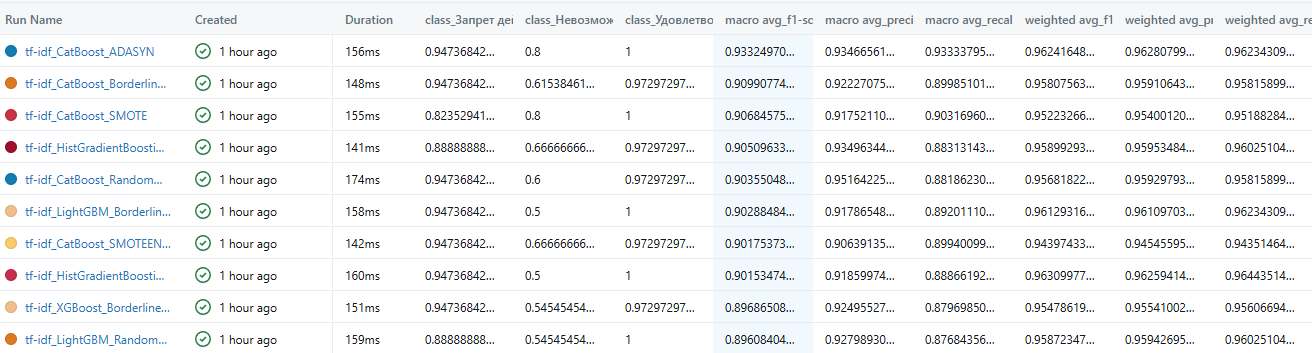
Первые 3 столбца - это самые редкие классы через показатель F1, остальные столбцы это средние метрики с весами и без.  
Стоит заметить, что это было до добавления новых классов из кластеризации, теперь эта модель не самая лучшая. Она плохо сработала на 3 редких классах, раньше был только 1 редкий класс.

Оставил обучение модели, если нужно будет проверить вероятности предсказанных примеров. Но, скорее всего, все оставшиеся примеры в датасете не относятся ни к одному классу.

In [ ]:
# %%script cmd /c ""
from src.classification_utils import load_np_arrays

# Бёрем методы из готовых кортежей
classifier_name = 'catboost'
classifier = [c for name, c in get_classifiers(le) if name == classifier_name][0]

resampler_name = 'adasyn'
resampler = [r for name, r in get_resamplers() if name == resampler_name][0]

vectorizer_name = 'tf_idf'
train_path, test_path = vectorizers[vectorizer_name]

# В кортеже векторизатора хранятся ссылки на файлы массивов, не сами вектора
X_train_vec, X_test_vec = load_np_arrays(train_path, test_path)

In [ ]:
# %%script cmd /c ""
from sklearn.metrics import classification_report
import warnings

warnings.filterwarnings('ignore')

X_train_fit, y_train_fit = resampler.fit_resample(X_train_vec, y_train_enc)
classifier.fit(X_train_fit, y_train_fit)

y_pred = classifier.predict(X_test_vec)
# y_proba = classifier.predict_proba(X_test_vec)

y_pred_labels = le.inverse_transform(y_pred)

print(f'Модель: {vectorizer_name}_{classifier_name}_{resampler_name}')
print(classification_report(y_test, y_pred_labels, digits=3))

Модель: tf-idf_CatBoost_ADASYN
                                        precision    recall  f1-score   support

                    Взыскание обращено      0.909     0.968     0.938        31
Возбуждено исполнительное производство      0.762     0.727     0.744        22
                       Запрет действий      1.000     0.750     0.857         4
                      Запрос направлен      0.952     0.833     0.889        24
    Заявления и жалобы рассматриваются      0.538     0.875     0.667         8
                 Обращение рассмотрено      0.868     0.846     0.857        39
        Объявлен исполнительный розыск      0.857     1.000     0.923         6
                                 Отказ      0.984     0.938     0.960        64
                Постановление вынесено      0.833     0.909     0.870        11
         Применены меры для исполнения      0.625     0.833     0.714         6
                 Производство окончено      1.000     0.667     0.800         3
        

Выберем векторизацию tf-idf, так как она показала лучший результат по всем моделям классификации.  
Для кластеризации возьмём HDBSCAN, так как ему почти ничего не надо указывать в параметрах, в отличие от других методов.

In [ ]:
from sklearn.metrics import classification_report
import pickle

df_unlabeled = df[df['answer'].isna()].copy()
df_unlabeled = df_unlabeled.reset_index(drop=True)

with open('models/vectorization/tf_idf_vectorizer.pkl', 'rb') as f:
    tf_idf_loaded = pickle.load(f)

X_unlabeled_tf_idf = tf_idf_loaded.transform(df_unlabeled['lemmatized_text'])
# X_unlabeled_arr = X_unlabeled_tf_idf.toarray()

In [ ]:
# Можно было использовать HDBSCAN из scikit-learn.cluster,
# но я не могу найти разницы, кроме того, что hdbscan считается лучше как отдельная библиотека под метод.
# И ещё то, что с sklearn можно было бы использовать Pipeline
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=5, metric='cosine')
clusters = clusterer.fit_predict(X_unlabeled_tf_idf)
df_unlabeled['cluster'] = clusters

for cl in sorted(df_unlabeled['cluster'].unique()):
    print(f"\n=== Кластер {cl} ===")
    display(df_unlabeled[df_unlabeled['cluster']==cl][['lemmatized_text']].head(15))

Делал примерно так по ручному  
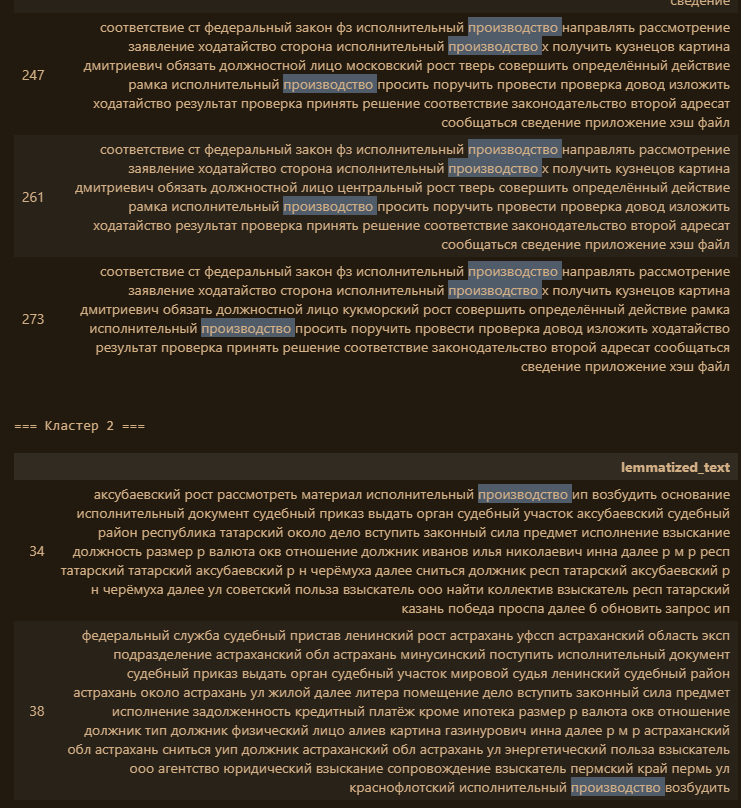

В итоге ещё добавил 200 примеров:  
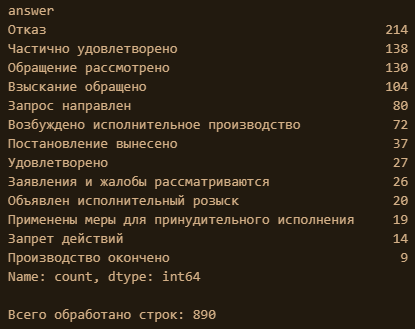
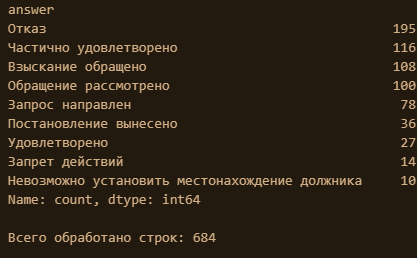